In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

%matplotlib inline

In [2]:
img_1 = mpimg.imread("first_frame.png")
img_2 = mpimg.imread("second_frame.png")
img_3 = mpimg.imread("lighthouse.png")[:, :, 0]

In [46]:
def dft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( - 2 * np.pi * 1j / N )
    W = np.power( omega, i * j )
    return W

def idft_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp(2 * np.pi * 1j / N )
    W = np.power( omega, i * j ) / N
    return W

def dft_2(I):
    (M, N) = I.shape
    
    W_N = dft_matrix(N)
    W_M = dft_matrix(M)
    
    It = np.zeros((M, N), dtype=complex)
    It = W_M@I@W_N
    return It

def idft_2(It):
    (M, N) = It.shape
    W_N = idft_matrix(N)
    W_M = idft_matrix(M)
    
    I = np.zeros((M, N), dtype=int)
    I = np.clip(np.real(W_M@It@W_N), 0, 255)
    return I

def linear_convolve_dft(f, h):
    (M, N) = f.shape
    (m, n) = h.shape
    
    h_padded = np.vstack((np.hstack((h, np.zeros((m, 2*N - n)))), np.zeros((2*M-m, 2*N))))
    f_padded = np.vstack((np.hstack((f, np.zeros((M, N)))), np.zeros((M, 2*N))))
    return idft_2(dft_2(h_padded) * dft_2(f_padded))[:M, :N]

def gaussian_filter(sigma, N):
    H = np.zeros((N, N))

    mid = N//2
    for i in range(N):
        for j in range(N):
            H[i, j] = np.exp(-2*np.power(np.pi*sigma, 2)*((mid-i)**2 + (mid-j)**2)/(N**2))
    return H/np.sum(H)

In [38]:
# def dft_matrix(N):
#     i, j = np.meshgrid(np.arange(N), np.arange(N))
#     omega = np.exp( - 2 * np.pi * 1j / N )
#     W = np.power( omega, i * j )
#     return W

# def idft_matrix(N):
#     i, j = np.meshgrid(np.arange(N), np.arange(N))
#     omega = np.exp(2 * np.pi * 1j / N )
#     W = np.power( omega, i * j ) / N
#     return W

# def dft(I):
#     (M, N) = I.shape
    
#     W_N = dft_matrix(N)
#     W_M = dft_matrix(M)
    
#     It = np.zeros((M, N), dtype=complex)
#     It = W_M@I@W_N
#     return It

# def idft(It):
#     (M, N) = It.shape
#     W_N = idft_matrix(N)
#     W_M = idft_matrix(M)
    
#     I = np.zeros((M, N), dtype=int)
#     I = np.clip(np.real(W_M@It@W_N), 0, 255)
#     return I

# def CONVOLVE(f, h):
#     (M, N) = f.shape
#     (m, n) = h.shape
#     mid_m = (m-1)//2
#     mid_n = (n-1)//2
#     y = np.zeros((M, N))
#     h_padded = np.vstack((np.hstack((h, np.zeros((m, 2*N - n)))), np.zeros((2*M-m, 2*N))))
#     f_padded = np.vstack((np.hstack((f, np.zeros((M, N)))), np.zeros((M, 2*N))))
#     y += idft(dft(h_padded) * dft(f_padded))[mid_m:(M+mid_m), mid_n:(N+mid_m)]
#     return y.astype(int)

# def gaussian_filter(sigma, N, C):
#     H = np.zeros((N, N, C))
#     for k in range(C):
#         mid = N//2
#         for i in range(N):
#             for j in range(N):
#                 H[i, j, k] = np.exp(-2*np.power(np.pi*sigma, 2)*((mid-i)**2 + (mid-j)**2)/(N**2))
#         H[:, :, k] = H[:, :, k]/np.sum(H[:, :, k])
#     return H

# def gaussian_bandpass(sigma1, sigma2, N, C):
#     h = gaussian_filter(sigma2, N, C) - gaussian_filter(sigma1, N, C)
#     return h/np.sum(h)

# Motion Estimation

# SSIM Index

In [4]:
def weights(P, Q):
    W = np.ones((P, Q))
    return W/(P*Q)

def luminance_similarity(I, J, P, Q, C1=(0.01*255)**2):
    W = weights(P, Q)
    M, N = I.shape
    I_padded = np.zeros((M+2*P, N+2*Q))
    I_padded[P:(M+P), Q:(N+Q)] = I
    J_padded = np.zeros((M+2*P, N+2*Q))
    J_padded[P:(M+P), Q:(N+Q)] = J
    mu_i = np.zeros((M, N))
    mu_j = np.zeros((M, N))
    L = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            mu_i[i, j] = np.sum(W*I_padded[i:(i+P), j:(j+Q)])
            mu_j[i, j] = np.sum(W*J_padded[i:(i+P), j:(j+Q)])
            L[i, j] = (2*mu_i[i, j]*mu_j[i, j]+C1)/(mu_i[i, j]**2 + mu_j[i, j]**2 + C1)
    return L

def contrast_similarity(I, J, P, Q, C2=(0.03*255)**2):
    W = weights(P, Q)
    M, N = I.shape
    I_padded = np.zeros((M+2*P, N+2*Q))
    I_padded[P:(M+P), Q:(N+Q)] = I
    J_padded = np.zeros((M+2*P, N+2*Q))
    J_padded[P:(M+P), Q:(N+Q)] = J
    mu_i = np.zeros((M, N))
    sigma_i = np.zeros((M, N))
    mu_j = np.zeros((M, N))
    sigma_j = np.zeros((M, N))
    C = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            mu_i[i, j] = np.sum(W*I_padded[i:(i+P), j:(j+Q)])
            sigma_i[i, j] = np.sqrt(np.sum(W*np.power(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j], 2)))
            mu_j[i, j] = np.sum(W*J_padded[i:(i+P), j:(j+Q)])
            sigma_j[i, j] = np.sqrt(np.sum(W*np.power(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j], 2)))
            C[i, j] = (2*sigma_i[i, j]*sigma_j[i, j]+C2)/(sigma_i[i, j]**2 + sigma_j[i, j]**2 + C2)
    return C

def structural_similarity(I, J, P, Q, C3=0.5*(0.03*255)**2):
    W = weights(P, Q)
    M, N = I.shape
    I_padded = np.zeros((M+2*P, N+2*Q))
    I_padded[P:(M+P), Q:(N+Q)] = I
    J_padded = np.zeros((M+2*P, N+2*Q))
    J_padded[P:(M+P), Q:(N+Q)] = J
    mu_i = np.zeros((M, N))
    sigma_i = np.zeros((M, N))
    mu_j = np.zeros((M, N))
    sigma_j = np.zeros((M, N))
    sigma_ij = np.zeros((M, N))
    S = np.zeros((M, N))
    for i in range(M):
        for j in range(N):
            mu_i[i, j] = np.sum(W*I_padded[i:(i+P), j:(j+Q)])
            sigma_i[i, j] = np.sqrt(np.sum(W*np.power(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j], 2)))
            mu_j[i, j] = np.sum(W*J_padded[i:(i+P), j:(j+Q)])
            sigma_j[i, j] = np.sqrt(np.sum(W*np.power(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j], 2)))
            sigma_ij[i, j] = np.sqrt(np.sum(W*(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j])*(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j])))
            S[i, j] = (sigma_ij[i, j]+C3)/(sigma_i[i, j]*sigma_j[i, j] + C3)
    return S

def SSIM(I, J, P, Q, C1=(0.01*255)**2, C2=(0.03*255)**2, C3=0.5*(0.03*255)**2):
    M, N = I.shape
    L = luminance_similarity(I, J, P, Q, C1)
    C = contrast_similarity(I, J, P, Q, C2)
    S = structural_similarity(I, J, P, Q, C3)
    return (1/(M*N))*(L*C*S)[P:, Q:]
    
var = 0.01
img_3_noise = img_3 + np.sqrt(var)*np.random.normal(size=img_3.shape)

sigma = 0.01
img_3_blur = linear_convolve_dft(img_3, gaussian_filter(sigma, 5))

img_3_noise_ssim = SSIM(img_3, img_3_noise, 11, 11)
img_3_blur_ssim = SSIM(img_3, img_3_blur, 11, 11)

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)
<ipython-input-4-94985445bb0b>:62: RuntimeWarning: invalid value encountered in sqrt
  sigma_ij[i, j] = np.sqrt(np.sum(W*(I_padded[i:(i+P), j:(j+Q)] - mu_i[i, j])*(J_padded[i:(i+P), j:(j+Q)] - mu_j[i, j])))


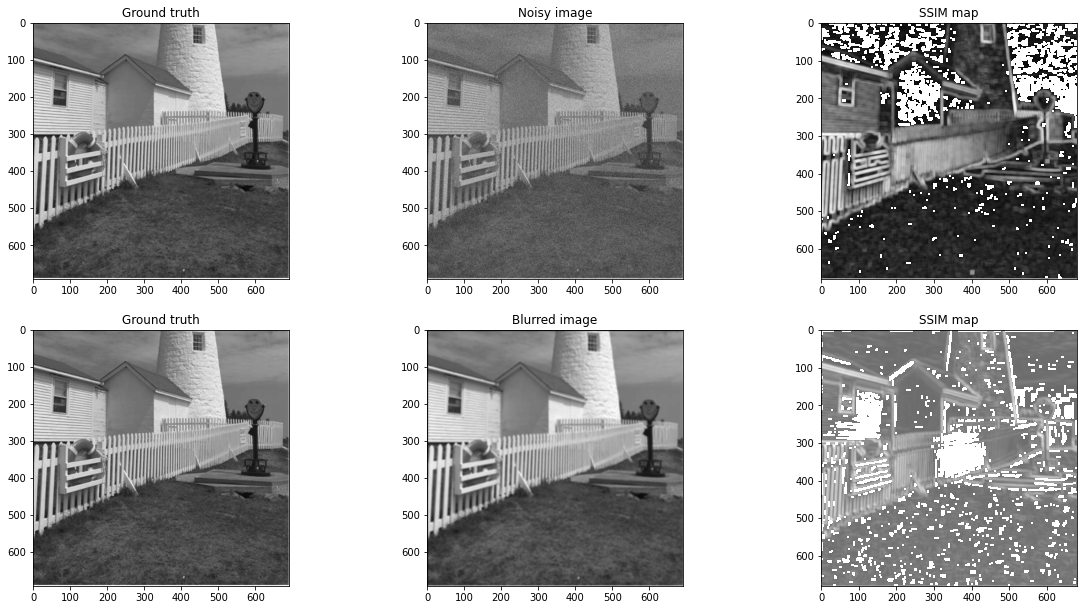

In [5]:
plt.rcParams["figure.figsize"] = (20, 16)

plt.subplot(3, 3, 1)
plt.title("Ground truth")
plt.imshow(img_3, cmap="gray")

plt.subplot(3, 3, 2)
plt.title("Noisy image")
plt.imshow(img_3_noise, cmap="gray")

plt.subplot(3, 3, 3)
plt.title("SSIM map")
plt.imshow(img_3_noise_ssim, cmap="gray")

plt.subplot(3, 3, 4)
plt.title("Ground truth")
plt.imshow(img_3, cmap="gray")

plt.subplot(3, 3, 5)
plt.title("Blurred image")
plt.imshow(img_3_blur, cmap="gray")

plt.subplot(3, 3, 6)
plt.title("SSIM map")
plt.imshow(img_3_blur_ssim, cmap="gray")

# Edge detection

## Gradient Edge Detectors

### Question 1

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)


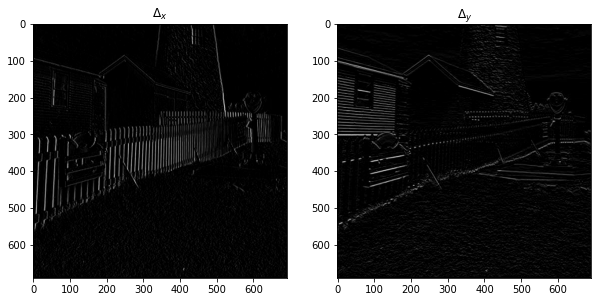

In [6]:
## Centered 2-D differencing
kx = 0.5*np.array([-1, 0, 1]).reshape(1, 3)
ky = kx.T
Dx_a = linear_convolve_dft(img_3, kx)
Dy_a = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_a, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_a, cmap="gray")

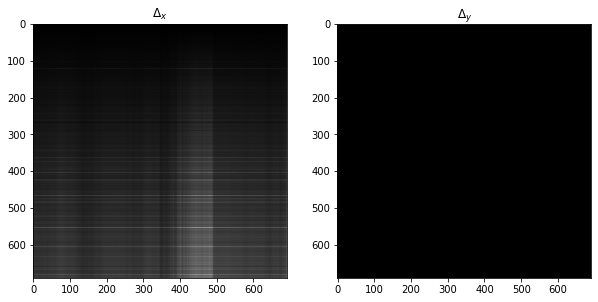

In [47]:
## Roberts operator
kx = np.matrix([[-1, 0], [0, 1]])
ky = np.matrix([[0, -1], [1, 0]])
Dx_b = linear_convolve_dft(img_3, kx)
Dy_b = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_b, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_b, cmap="gray")

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)


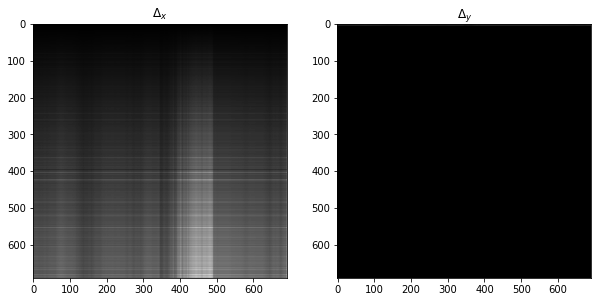

In [8]:
## Prewitt operator
kx = np.matrix([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])/3
ky = kx.T
Dx_c = linear_convolve_dft(img_3, kx)
Dy_c = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_c, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_c, cmap="gray")

<ipython-input-3-cefd2b3426db>:19: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  It = np.zeros((M, N), dtype=np.complex)


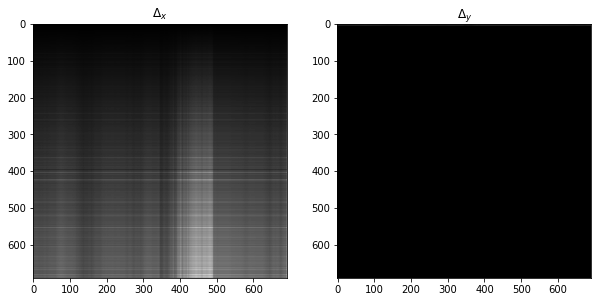

In [9]:
## Sobel differencing
kx = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])/4
ky = kx.T
Dx_d = linear_convolve_dft(img_3, kx)
Dy_d = linear_convolve_dft(img_3, ky)

plt.rcParams["figure.figsize"] = (10, 8)

plt.subplot(1, 2, 1)
plt.title(r'${\Delta}_x$')
plt.imshow(Dx_c, cmap="gray")

plt.subplot(1, 2, 2)
plt.title(r'${\Delta}_y$')
plt.imshow(Dy_c, cmap="gray")

### Question 2

In [21]:
## a
M_a = np.sqrt(np.power(Dx_a, 2) + np.power(Dy_a, 2))

In [22]:
## b
M_b = np.absolute(Dx_a) + np.absolute(Dy_a)

In [23]:
## c
M_c = np.maximum(np.absolute(Dx_a), np.absolute(Dy_a))

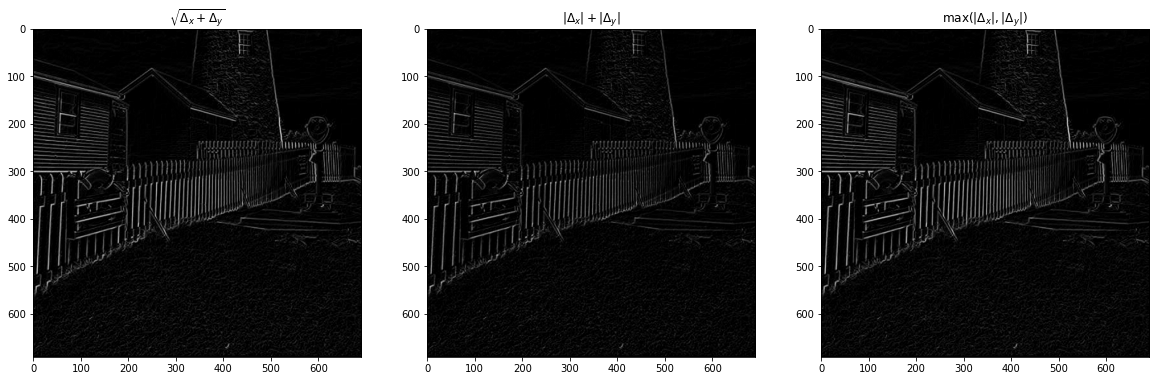

In [25]:
plt.rcParams["figure.figsize"] = (20, 16)

plt.subplot(1, 3, 1)
plt.title(r'$\sqrt{{{\Delta}_x} + {{\Delta}_y}}$')
plt.imshow(M_a, cmap="gray")

plt.subplot(1, 3, 2)
plt.title(r'${|{{\Delta}_x}| + |{{\Delta}_y}|}$')
plt.imshow(M_b, cmap="gray")

plt.subplot(1, 3, 3)
plt.title(r'max($|{{\Delta}_x}|, |{{\Delta}_y}|$)')
plt.imshow(M_c, cmap="gray")

## Laplacian Edge Detectors

### Question 1

In [90]:
K = np.matrix([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
L = linear_convolve_dft(img_3, K)

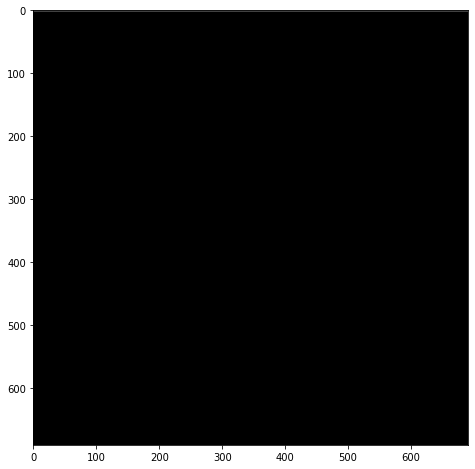

In [91]:
plt.rcParams["figure.figsize"] = (10, 8)
plt.imshow(L, cmap="gray")

### Question 2

In [50]:
def ZC_detection(L):
    M, N = L.shape
    I = np.zeros(L.shape, dtype=int)
    for i in range(M-2):
        for j in range(N-2):
            if L[i, j] > 0:
                if L[i, j+1] < 0:
                    I[i, j+1] = 1
                elif L[i, j+1] == 0:
                    if L[i, j+2] > 0:
                        L[i, j+1] = 0
                if L[i+1, j] < 0:
                    I[i+1, j] = 1
                elif L[i+1, j] == 0:
                    if L[i+2, j] > 0:
                        L[i+1, j] = 0
            elif L[i, j] < 0:
                if L[i, j+1] > 0:
                    I[i, j+1] = 1
                elif L[i, j+1] == 0:
                    if L[i, j+2] < 0:
                        L[i, j+1] = 0
                if L[i+1, j] > 0:
                    I[i+1, j] = 1
                elif L[i+1, j] == 0:
                    if L[i+2, j] < 0:
                        L[i+1, j] = 0
    return I

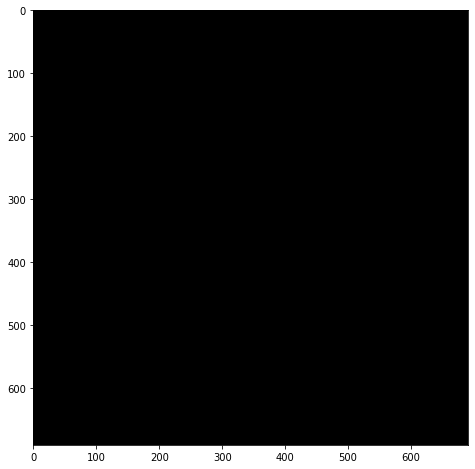

In [53]:
E = ZC_detection(L)
plt.imshow(E, cmap="gray")

## Laplacian of Gaussian(LoG)

In [64]:
def sampled_LoG(sigma, N):
    H = np.zeros((N, N))

    mid = N//2
    for i in range(N):
        for j in range(N):
            H[i, j] = (1 - ((mid-i)**2 + (mid-j)**2)/((N*sigma)**2))*np.exp(-0.5*((mid-i)**2 + (mid-j)**2)/((N*sigma)**2))
    return H/np.sum(H)

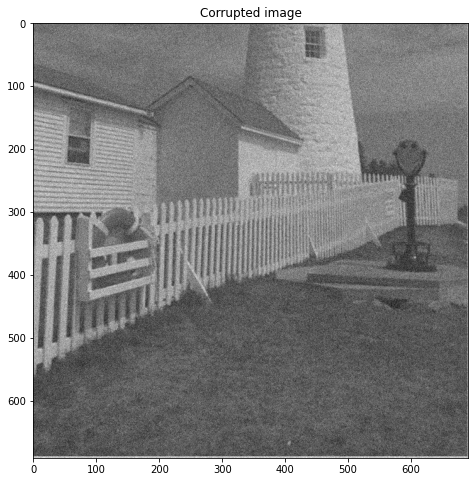

In [84]:
img_3_awgn = img_3 + np.random.normal(0, 0.1, img_3.shape)

plt.title("Corrupted image")
plt.imshow(img_3_awgn, cmap="gray")

In [92]:
sigma = 10
img_3_log = linear_convolve_dft(img_3_awgn, sampled_LoG(sigma, 5))

L = linear_convolve_dft(img_3_log, K)

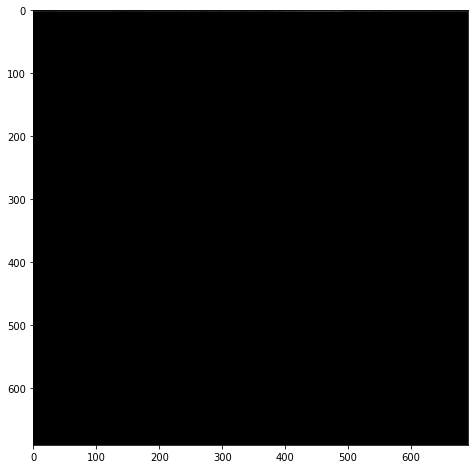

In [93]:
plt.imshow(L, cmap="gray")